## 概览
- 在这个案例中，我们将展示如何通过Paddle Quantum训练量子神经网络来求解量子系统的特征。

- 首先，让我们通过下面几行代码引入必要的library和package。

In [ ]:
import os
from numpy import concatenate
from numpy import pi as PI
from numpy import savez, zeros
from paddle import fluid
from paddle.complex import matmul, transpose
from paddle_quantum.circuit import UAnsatz
import matplotlib.pyplot as plt
import numpy
from paddle_quantum.VQE.chemistrysub import H2_generator

## 背景
- 量子计算中在近期非常有前途的一个量子算法是变分量子特征求解器(VQE, variational quantum eigensolver (VQE)) [1-3].
- VQE是量子化学在近期有噪量子设备（NISQ device）上的核心应用之一。其核心是去求解一个物理系统的哈密顿量的基态及其对应的能量。数学上，可以理解为求解一个厄米矩阵(Hermitian matrix)的最小特征值及其对应的特征向量。
- 接下来我们将通过一个简单的例子学习如何通过训练量子神经网络解决这个问题，我们的目标是通过训练量子神经网络去找到量子态 $\left| \phi  \right\rangle $ (可以理解为一个归一化的复数向量), 使得 $$\left\langle \phi  \right|H\left| \phi  \right\rangle =\lambda_{\min}(H)$$, 其中$\left\langle \phi  \right|$是$\left| \phi  \right\rangle$的共轭转置，$\lambda_{\min}(H)$是矩阵$H$的最小特征值。

## VQE分析氢分子的性质
- 对于具体需要分析的分子，我们需要输入其几何、电荷构型等多项信息。具体的，通过我们内置的量子化学工具包可以利用fermionic-to-qubit映射的技术来输出目标分子的量子比特哈密顿量表示。
- 在这里，作为简单的入门案例，我们提供已经映射好的的氢分子的哈密顿量。 

In [ ]:
Hamiltonian, _, N = H2_generator()

## 搭建量子神经网络（QNN）
- 在实现VQE的过程中，我们首先需要设计1个量子神经网络QNN（也可以理解为参数化量子电路）。这里，我们提供一个简单的d层的4量子位的量子电路如下：

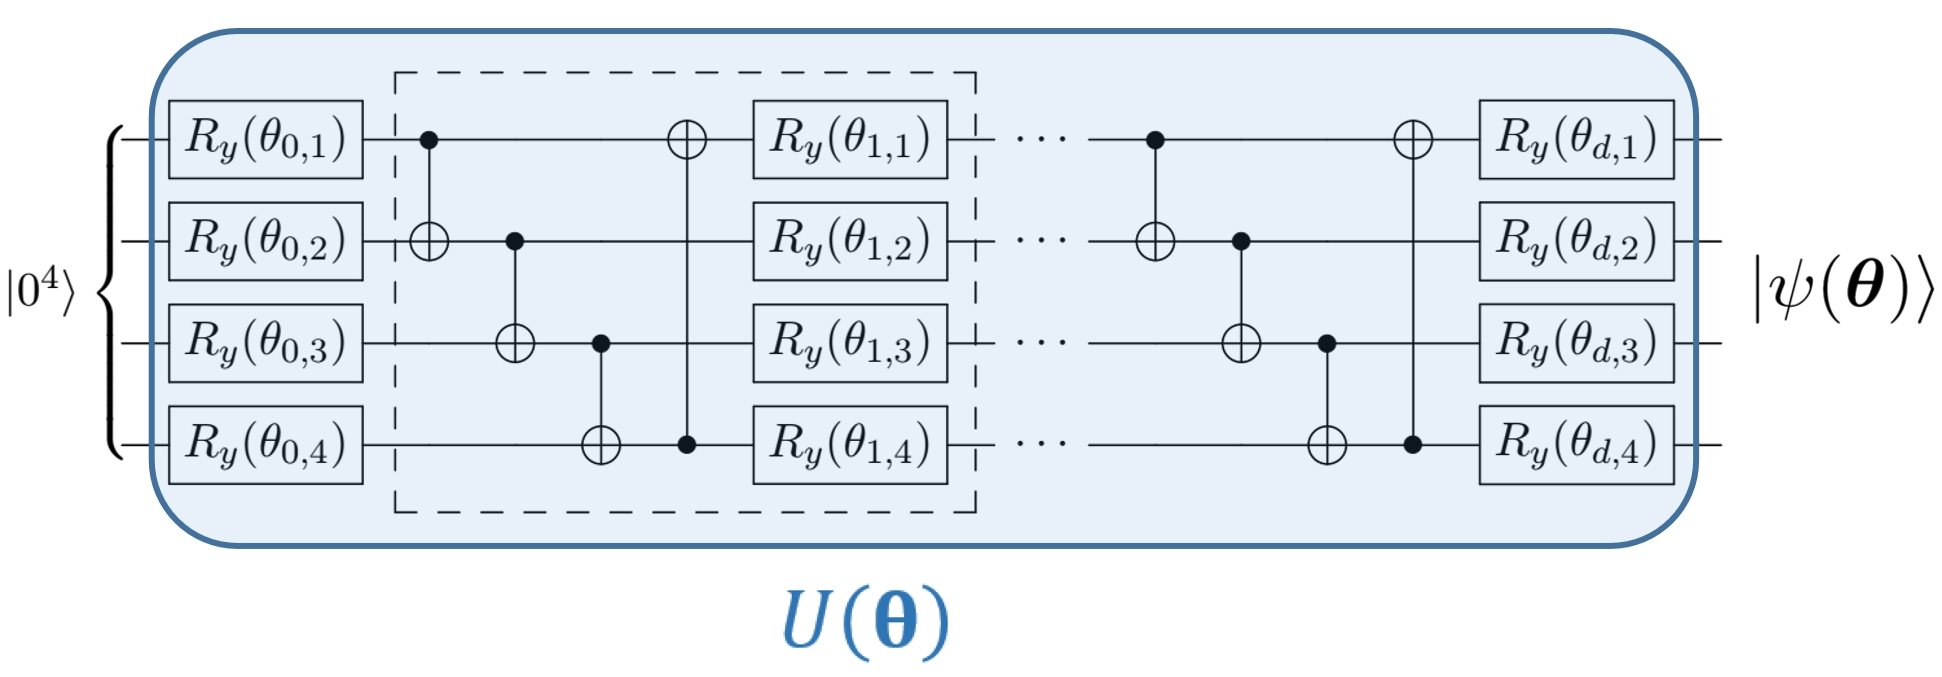

- 我们预设一些该参数化电路的参数，比如宽度为4量子位。

- 初始化其中的变量参数，${\bf{\theta }}$代表我们量子神经网络中的参数组成的向量。

In [ ]:
def U_theta(theta, input_state, N, D):
    """
    Circuit
    """

    cir = UAnsatz(N, input_state=input_state)
    for i in range(N):
        cir.ry(theta=theta[0][1][i], which_qubit=i + 1)
        
    for repeat in range(D):
        for i in range(1, N):
            cir.cnot(control=[i, i + 1])
         
        for i in range(N):
            cir.ry(theta=theta[repeat][0][i], which_qubit=i + 1)
    return cir.state

## 配置训练模型 - 损失函数
- 现在我们已经有了数据和量子神经网络的架构，我们将进一步定义训练参数、模型和损失函数.
- 设置训练模型中的的损失函数。通过作用量子神经网络$U(\theta)$在初始态上，我们将得到输出态$\left| {\psi \left( {\bf{\theta }} \right)} \right\rangle $。进一步，在VQE模型中的损失函数一般由哈密顿量H与量子态$\left| {\psi \left( {\bf{\theta }} \right)} \right\rangle$的内积给出，具体可定义为
$$\left\langle {\psi \left( {\bf{\theta }} \right)} \right|H\left| {\psi \left( {\bf{\theta }} \right)} \right\rangle.$$

In [ ]:
class StateNet(fluid.dygraph.Layer):
    """
    Construct the model net
    """

    def __init__(
        self,
        shape,
        param_attr=fluid.initializer.Uniform(low=0.0, high=2 * PI),
        dtype="float32",
    ):
        super(StateNet, self).__init__()
        self.theta = self.create_parameter(
            shape=shape, attr=param_attr, dtype=dtype, is_bias=False
        )

    def forward(self, input_state, H, N, D):
        """
        :param input_state: The initial state with default |0..>, 'mat'
        :param H: The target Hamiltonian, 'mat'
        :return: The loss, 'float'
        """

        out_state = U_theta(self.theta, input_state, N, D)
        loss = matmul(
            matmul(out_state, H),
            transpose(
                fluid.framework.ComplexVariable(out_state.real, -out_state.imag),
                perm=[1, 0],
            ),
        )

        return loss.real
    

## 配置训练模型 - 模型参数
在进行量子神经网络的训练之前，我们还需要进行一些训练（超）参数的设置，例如学习速率与迭代次数。
- 设定模型的初始态为零态。
- 设定量子神经网络的深度为2层。
- 设定学习速率（learning rate）为0.2, 迭代次数为80次。

In [ ]:
d = 2
ITR = 80
LR = 0.3

## 进行训练

- 当训练模型的各项参数都设置完成后，我们将数据转化为Paddle动态图中的变量，进而进行量子神经网络的训练。
- 过程中我们用的是Adam Optimizer，也可以调用Paddle中提供的其他优化器。
- 我们将训练过程中的结果存储在summary_data文件中。

In [ ]:
with fluid.dygraph.guard():
    # initial state preparing
    _initial_state_np = concatenate(
        ([[1.0]], zeros([1, 2 ** N - 1])), axis=1
    ).astype("complex64")
    initial_state = fluid.dygraph.to_variable(_initial_state_np)

    # Store H
    H = fluid.dygraph.to_variable(Hamiltonian)

    # net
    net = StateNet(shape=[d + 1, 3, N])

    # optimizer
    opt = fluid.optimizer.AdamOptimizer(
        learning_rate=LR, parameter_list=net.parameters()
    )

    # gradient descent loop
    summary_iter, summary_loss = [], []
    for itr in range(1, ITR + 1):
        # forward calc, loss
        loss = net(initial_state, H, N, d)

        # backward calculation for gradient value
        loss.backward()
        # using gradients to update the variable theta
        opt.minimize(loss)
        # clear gradients
        net.clear_gradients()

        summary_loss.append(loss[0][0].numpy())
        summary_iter.append(itr)

        print("iter:", itr, "loss:", "%.4f" % loss.numpy())
        print("iter:", itr, "Ground state energy:", "%.4f Ha" % loss.numpy())
        # print('theta:', net.parameters()[0].numpy())

    os.makedirs("output", exist_ok=True)
    savez("./output/summary_data", iter=summary_iter, energy=summary_loss)


## 测试效果
我们现在已经完成了量子神经网络的训练，得到的基态能量的估计值大致为-1.136 Ha，我们将通过与理论值的对比来测试效果。
- 训练后得到的QNN作用在初始零态上就是VQE算法的输出态，最后更新的损失函数则为其对应的能量。
- 接下来我们将训练QNN得到的基态能量和理想情况下的理论值。
- 我们可以先求解理论值，即哈密顿量$H$的最小特征值。

In [ ]:
x1 = numpy.load('./output/summary_data.npz')

eig_val, eig_state = numpy.linalg.eig(Hamiltonian)
min_eig_H = numpy.min(eig_val)
min_loss = numpy.ones([len(x1['iter'])]) * min_eig_H

plt.figure(1)
func1, = plt.plot(x1['iter'], x1['energy'], alpha=0.7, marker='', linestyle="--", color='m')
func_min, = plt.plot(x1['iter'], min_loss, alpha=0.7, marker='', linestyle=":", color='b')
plt.xlabel('Number of iteration')
plt.ylabel('Energy (Ha)')

plt.legend(handles=[
    func1,
    func_min
],
    labels=[
        r'$\left\langle {\psi \left( {\bf{\theta }} \right)} '
        r'\right|H\left| {\psi \left( {\bf{\theta }} \right)} \right\rangle $',
        'Minimum energy',
    ], loc='best')

# output the picture
plt.show()


## 参考文献
[1] A. Peruzzo et al., “A variational eigenvalue solver on a photonic quantum processor,” Nat. Commun., vol. 5, no. 1, p. 4213, Dec. 2014.

[2] S. McArdle, S. Endo, A. Aspuru-Guzik, S. C. Benjamin, and X. Yuan, “Quantum computational chemistry,” Rev. Mod. Phys., vol. 92, no. 1, p. 015003, Mar. 2020.

[3] Y. Cao et al., “Quantum chemistry in the age of quantum computing,” Chem. Rev., vol. 119, no. 19, pp. 10856–10915, 2019.



